In [21]:
from src.gc_dataset import GCSDataset
from icvf_envs.antmaze import d4rl_utils
from src.subgoals import SUBGOALS
SUBGOALS = SUBGOALS['large']
import jax
import jax.numpy as jnp
from src import icvf_learner as learner
from src.icvf_networks import icvfs, create_icvf
from flax.serialization import from_state_dict
import h5py
import matplotlib.pyplot as plt
import pickle
from PIL import Image

In [2]:
env = d4rl_utils.make_env('antmaze-large-diverse-v2')
dataset = d4rl_utils.get_dataset(env)

/nfs/kun1/users/dashora7/miniconda3/envs/rlpd/lib/python3.9/site-packages/gym/spaces/box.py:84: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Target Goal:  (32.52347476921716, 24.53939208415479)


load datafile: 100%|██████████| 8/8 [00:01<00:00,  4.36it/s]


In [3]:
gcdataset_config = GCSDataset.get_default_config()
gcdataset_config['p_samegoal'] = 0.0
gcdataset_config['p_currgoal'] = 0.0
gcdataset_config['p_randomgoal'] = 0.0
gcdataset_config['p_trajgoal'] = 1.0
gcdataset_config['intent_sametraj'] = True
gc_dataset = GCSDataset(dataset, **gcdataset_config, hiql_mode=True)
gcdataset_config['p_samegoal'] = 0.0
gcdataset_config['p_currgoal'] = 0.0
gcdataset_config['p_randomgoal'] = 1.0
gcdataset_config['p_trajgoal'] = 0.0
gcdataset_config['intent_sametraj'] = False
random_gc_dataset = GCSDataset(dataset, **gcdataset_config, hiql_mode=True)


In [34]:
start, end = 804804, 805114
fpath = '/home/dashora7/hard_antmaze.hdf5'
data = h5py.File(fpath, 'r')
obses = data['observations']
exp_slice = obses[start:end]
subgoal_idxs = [0, 30, 50, 90, 115, 135, 150, 175, 200, 225, 260, 285, 309]
goal = exp_slice[-1]

icvf_path = "/nfs/kun2/users/dashora7/antmaze-large-icvf.pkl"   
with open(icvf_path, 'rb') as f:
    icvf_params = pickle.load(f)
params_icvf = icvf_params['agent']
conf_icvf = icvf_params['config']
value_def = create_icvf('multilinear', hidden_dims=[256, 256])
ag = learner.create_learner(
    seed=42, observations=jnp.ones((1, 29)),
    value_def=value_def, **conf_icvf)
ag = from_state_dict(ag, params_icvf)
icvf_fn = jax.jit(lambda a, b, c: ag.value(a, b, c).sum(0))

Extra kwargs: {}


/nfs/kun1/users/dashora7/miniconda3/envs/rlpd/lib/python3.9/site-packages/flax/core/lift.py:66: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys.
  fn, tree, is_leaf=lambda x: isinstance(x, random.KeyArray)


In [73]:
def plot_traj(traj, start, goal, subgoals):
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_facecolor('xkcd:light grey')
    ax.grid(True, color='white')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(start[0], start[1], c='g', s=100, label='start')
    ax.scatter(goal[0], goal[1], c='r', s=100, label='goal')
    ax.scatter(subgoals[:, 0], subgoals[:, 1], c='b', s=100, label='candidate subgoals')
    ax.plot(traj[:, 0], traj[:, 1], c='k', linewidth=3, label='trajectory')
    ax.legend()
    return fig

scales_shifts = [(6, 40), (-6, 230)]
def scale_and_shift(x, lst):
    return lst[0] * x + lst[1]
    

def plot_traj_image(traj, start, goal, subgoals, bgpath):
    fig, ax = plt.subplots(figsize=(5, 5))
    pimage = plt.imread(bgpath)
    ax.imshow(pimage)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(scale_and_shift(start[0], scales_shifts[0]), scale_and_shift(start[1], scales_shifts[1]), c='g', s=100, label='start')
    ax.scatter(scale_and_shift(goal[0], scales_shifts[0]), scale_and_shift(goal[1], scales_shifts[1]), c='r', s=100, label='goal')
    ax.scatter(scale_and_shift(subgoals[:, 0], scales_shifts[0]), scale_and_shift(subgoals[:, 1], scales_shifts[1]), c='b', s=100, label='candidate subgoals')
    # ax.plot(scale_and_shift(traj[:, 0], scales_shifts[0]), scale_and_shift(traj[:, 1], scales_shifts[1]),c='white', linewidth=3, label='trajectory')  
    ax.legend()
    return fig

def icvf_weights(batch, usefulness=1, reachability=1, verbose=False):
    obs = batch["observations"]
    subgoal = batch["actions"]
    goal = batch["desired_goals"] # this is z
    advantages = icvf_fn(subgoal, goal, goal) - icvf_fn(obs, goal, goal)
    value = icvf_fn(obs, subgoal, subgoal) - icvf_fn(obs, goal, goal)
    if verbose:
        print("V(sg, g, g)=", icvf_fn(subgoal, goal, goal))
        print("V(s, g, g)=", icvf_fn(obs, goal, goal))
        print("V(s, sg, sg)=", icvf_fn(obs, subgoal, subgoal))
        print("Advantage of going to sg from s: ", advantages)
        print("Ease of reaching sg from s: ", value)
    return advantages, value

V(sg, g, g)= [-48.334023]
V(s, g, g)= [-101.43855]
V(s, sg, sg)= [-53.610676]
Advantage of going to sg from s:  [53.10453]
Ease of reaching sg from s:  [47.827877]
Final datapoint weight 53.104530334472656


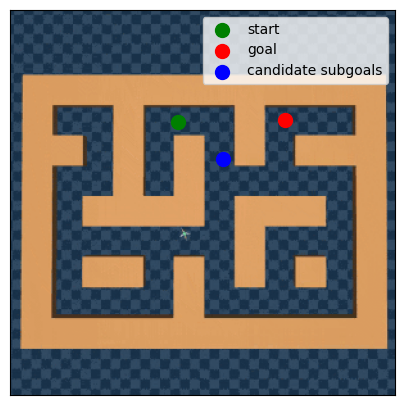

In [168]:
batch = gc_dataset.sample(1)
a, v = icvf_weights(batch)
while a < 10 or v < 40:
    batch = gc_dataset.sample(1)
    a, v = icvf_weights(batch)
w = icvf_weights(batch, verbose=True)

fig = plot_traj_image(
    exp_slice,
    batch["observations"][0],
    batch["goals"][0],
    batch["actions"][:, :2],
    "/home/dashora7/icvf_release/notebooks/antmaze-large.png"
)

fig.show()
print("Final datapoint weight", w[0].item())


V(sg, g, g)= [-44.820587]
V(s, g, g)= [-58.568794]
V(s, sg, sg)= [-17.990822]
Advantage of going to sg from s:  [13.748207]
Ease of reaching sg from s:  [40.577972]
Final datapoint weight 13.748207092285156


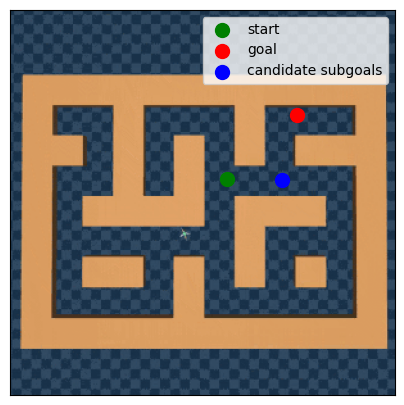

In [162]:
rbatch = random_gc_dataset.sample(1)
a, v = icvf_weights(rbatch)
while a < 10 or v < 40:
    rbatch = gc_dataset.sample(1)
    a, v = icvf_weights(rbatch)
w = icvf_weights(rbatch, verbose=True)

fig = plot_traj_image(
    exp_slice,
    rbatch["observations"][0],
    rbatch["goals"][0],
    rbatch["actions"][:, :2],
    "/home/dashora7/icvf_release/notebooks/antmaze-large.png"
)

fig.show()
print("Final datapoint weight", w[0].item())
